# UK Accident Analysis

**Problem Statement**

Accidents are a common phenomenon in cities and countries alike. From an urban planning and design standpoint, it is important to understand the characterisitics and causes of the accidents to ensure effective safety planning framework to reduce the occurrence of such accidents. 

There are three specific features to understand from the historical data to proceed with the solution:

**Hypothesis**

**Accident Severity**
- Are accidents in the UK preventable? How is the severity of accidents affected by reasons such as road type, speed limit, lighting etc.? 
- Given the correlation, are we able to predict whether the accident would be fatal or not? 
- How do the municipalities or state bodies ensure safety frameworks are enforced to reduce fatalities? 

**Police Response**
- Are the police responses varied in urban and rural settings? 
- What are the factors that influence the police response to accidents?

**Data Understanding**
At our disposal, we have a dataset published by the government of UK for accidents between 2012 to 2015. The dataset provides information about how the accidents happened, when the accidents happened, where the accidents happened, and what was the aftermath of the accident. Some of the data problems we face are as following: Missing values, Unknown values,  Imbalanced datasets for prediction, and data type issues. 

**Data Modelling and Recommendations**
Once we have addressed the dataset issues, we have to identify factors that influence accident severity (fatal or not). Given the association, we predict the severity of the accidents. Furthermore, we observe the controllable parameters and issue safety guideline recommendations that road safety bodies must follow. 

Moreover, we identify the factors that influence the police response to the accidents and identify causes and reasons that influence police response. In addition, we will provide recommendations to boost police response to accidents in high prone areas.


# Load Packages

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.datasets import make_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import imblearn
from statsmodels.graphics.mosaicplot import mosaic

# Data preprocessing

In [2]:
#Load Data
input=pd.read_csv('Dataset for analysis.csv')

#Drop unwanted columns
test=input.drop(['1st_Road_Class','2nd_Road_Class','Location_Easting_OSGR','Location_Northing_OSGR','1st_Road_Number','2nd_Road_Number','LSOA_of_Accident_Location', 'Local_Authority_(District)','Local_Authority_(Highway)'],axis=1)

#Impute missing values- Blanks, irregular, and unknown values
test=test.dropna()


In [3]:
# Remove Unknown values
a=['-1']
test = test[~test['Junction_Control'].isin(a)]
test = test[~test['Junction_Detail'].isin(a)]
test = test[~test['Light_Conditions'].isin(a)]
test = test[~test['Pedestrian_Crossing-Human_Control'].isin(a)]
test = test[~test['Pedestrian_Crossing-Physical_Facilities'].isin(a)]
test = test[~test['Road_Type'].isin(a)]
test = test[~test['Did_Police_Officer_Attend_Scene_of_Accident'].isin(a)]


In [4]:

#Convert to categorical variable
test['Accident_Severity'] = test['Accident_Severity'].astype('category')
test['ID'] = test['ID'].astype('category')
test['Police_Force'] = test['Police_Force'].astype('category')
test['Day_of_Week'] = test['Day_of_Week'].astype('category')
test['Road_Type'] = test['Road_Type'].astype('category')
test['Speed_limit'] = test['Speed_limit'].astype('category')
test['Junction_Detail'] = test['Junction_Detail'].astype('category')
test['Junction_Control'] = test['Junction_Control'].astype('category')
test['Pedestrian_Crossing-Human_Control'] = test['Pedestrian_Crossing-Human_Control'].astype('category')
test['Pedestrian_Crossing-Physical_Facilities'] = test['Pedestrian_Crossing-Physical_Facilities'].astype('category')
test['Light_Conditions'] = test['Light_Conditions'].astype('category')
test['Did_Police_Officer_Attend_Scene_of_Accident'] = test['Did_Police_Officer_Attend_Scene_of_Accident'].astype('category')
test['Urban_or_Rural_Area'] = test['Urban_or_Rural_Area'].astype('category')

#Combining data to address problem
test['Did_Police_Officer_Attend_Scene_of_Accident'] = test['Did_Police_Officer_Attend_Scene_of_Accident'].replace(3,2) #Combined did not attend to the scene classes


In [5]:
#Convert date and time column to appropriate date time format
test['Date'] = pd.to_datetime(test['Date'])
test['Time'] = pd.to_datetime(test['Time'])
test['year'] = test['Date'].dt.year
test['month_year'] = pd.to_datetime(test['Date']).dt.to_period('M')
test['month_year'] = test.month_year.values.astype('datetime64[M]')


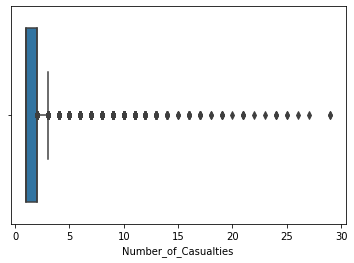

In [6]:
#Identifying and removing outliers in Number of vehicles and Casualties
veh = sns.boxplot(x=input["Number_of_Vehicles"])
casualties= sns.boxplot(x=input["Number_of_Casualties"])
veh



# Exploratory data analysis 

**Q1:Are the continuous varibles correlated?** 

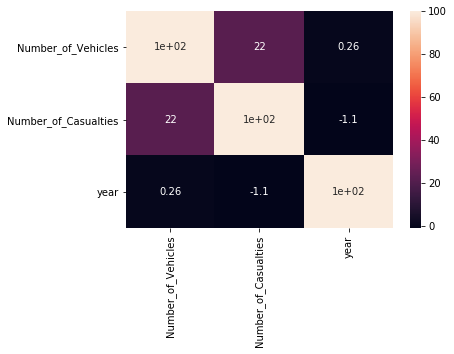

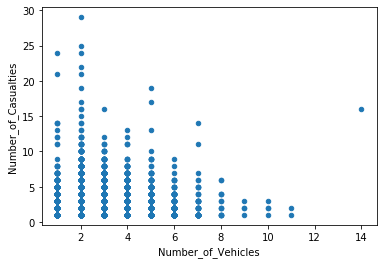

In [7]:
#Overview of correlated continuous variables

cor= test.drop(['Latitude','Longitude'],axis=1)
cor_mat= cor.corr()
sns.heatmap(cor_mat*100, annot=True)
plt.show()


#Number of vehicles vs Number of Casualties
ax2 = test.plot.scatter(x='Number_of_Vehicles',
                      y='Number_of_Casualties',
                       )


From the correlation matrix, none of the continuous variables are highly correlated. Moreover, the scatter plot between number of vehicles and number of collissions is almost inversely correlated. In other words, as the number of vehicles involved in collissions go up, the number of casualties go down. 

**Q2: How many accidents are fatal in the UK?**

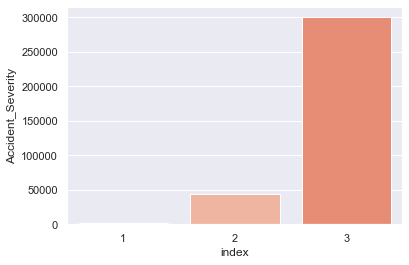

In [8]:
#Accident severity by speed limit
accident=test[['Accident_Severity']]

accident = pd.DataFrame(test['Accident_Severity'].value_counts().reset_index())
#accident
sns.set(font_scale=1, palette= "Reds")
count=sns.barplot(data = accident, x = "index", y = "Accident_Severity", dodge = True)
count

One of the initial considerations of the dataset is that the data is imbalanced across the classes. To further explain, there are 90% of the records are labellled as slight accidents (lowest grade), and only 10% of the samples across the other classes. 


**Q3: What is the distribution of accidents in urban and rural areas? How is accident severity different in urban and rural areas?** 

Urban_or_Rural_Area  Accident_Severity
1                    3                    87.449030
                     2                    12.036991
                     1                     0.513978
2                    3                    83.703941
                     2                    15.055948
                     1                     1.240111
Name: Accident_Severity, dtype: float64

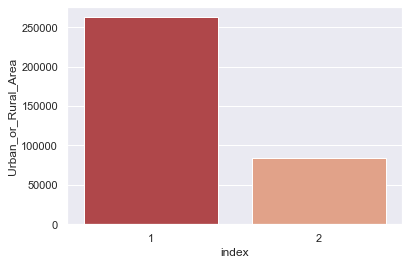

In [9]:
area=test[['Urban_or_Rural_Area']]
accident = pd.DataFrame(test['Urban_or_Rural_Area'].value_counts().reset_index())
sns.set(font_scale=1, palette= "RdBu")
count=sns.barplot(data = accident, x = "index", y = "Urban_or_Rural_Area", dodge = True)
test.groupby(['Urban_or_Rural_Area'])['Accident_Severity'].value_counts(normalize=True)*100

The number of accidents in urban areas are higher as compared to the rural areas. However, the % of serious accidents in rural areas are slightly higher than in urban areas. 

**Q3: How does lighting in the roads affect accident severity?**

In [10]:
lights = pd.DataFrame(test['Light_Conditions'].value_counts().reset_index())
lights_acc=pd.DataFrame(test.groupby(['Light_Conditions'])['Accident_Severity'].value_counts(normalize=True)*100)
lights_acc


Accident_Severity
Light_Conditions Accident_Severity                   
1                3                          87.181310
                 2                          12.215490
                 1                           0.603200
4                3                          85.148957
                 2                          14.034603
                 1                           0.816439
5                3                          84.094955
                 2                          14.836795
                 1                           1.068249
6                3                          78.203593
                 2                          19.146707
                 1                           2.649701
7                3                          86.642454
                 2                          12.853107
                 1                           0.504439

In the above table, we discuss the influence of lighting on the severity of accidents. 

As the lighting is darker, the accidents are more fatal indicating that lighting has an impact on the severity of accidents. Label 5 and 6 refer to darkness in the region of the accident. In view of that, the fatal accidents are higher for these regions. 

**Q4: Does police response vary by urban and rural region?**

In [11]:
test.groupby(['Urban_or_Rural_Area'])['Did_Police_Officer_Attend_Scene_of_Accident'].value_counts(normalize=True)*100

Urban_or_Rural_Area  Did_Police_Officer_Attend_Scene_of_Accident
1                    1                                              78.725486
                     2                                              21.274514
2                    1                                              85.275461
                     2                                              14.724539
Name: Did_Police_Officer_Attend_Scene_of_Accident, dtype: float64

**Police response to accidents is lower in urban as compared to police response in rural areas. **

Police response in rural areas are higher compared to poilce response in urban areas. The higher the severity of the accident, the higher the poice response and attendance to the accident. 

**Q5: Does accident severity vary by road type?**

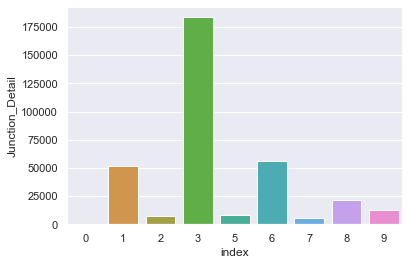

In [12]:
accident2 = pd.DataFrame(test['Junction_Detail'].value_counts().reset_index())
sns.set(font_scale=1, palette= "RdBu")
count=sns.barplot(data = accident2, x = "index", y = "Junction_Detail", dodge = True)

From first glance, the accident severity is influenced by road type, and junction detail. The highest number of accidents happen on T or staggered junction, followed by accidents on cross roads and roundabouts. 


**Seasonality and Occurences of Accidents**

year
2012    89240
2013    83845
2014    89854
2015    83904
Name: ID, dtype: int64


(array([734503., 734685., 734869., 735050., 735234., 735415., 735599.,
        735780., 735964.]), <a list of 9 Text xticklabel objects>)

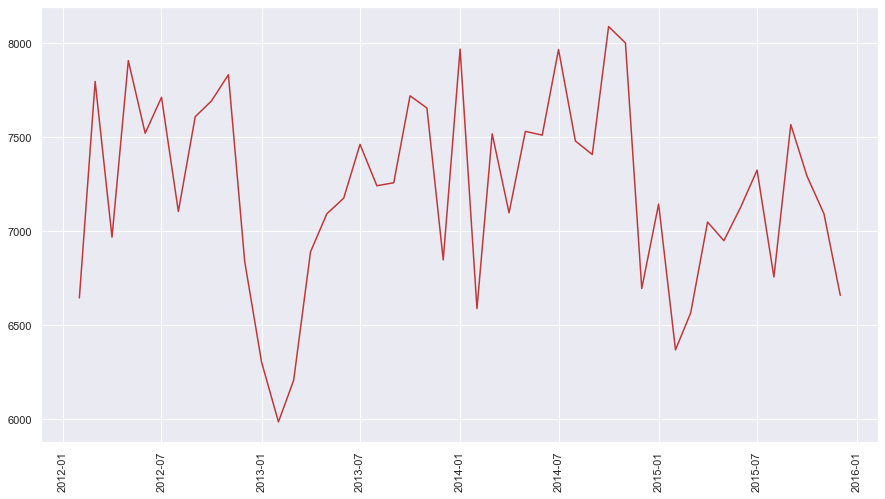

In [13]:
#Yearly number of accidents in the UK
yearly=test.groupby(['year'])['ID'].nunique()
print(yearly)

#Check for seasonality
test1=test[(test['month_year'] > '2012-01') & (test['Date'] < '2016-01')]
df = pd.DataFrame(test1['month_year'].value_counts().reset_index())
df.columns = ['month_year', 'count']
df = df.sort_values('month_year', ascending=False)
fig=plt.figure(figsize=(15,8))
plt.plot(df['month_year'], df['count'])
plt.xticks(rotation='vertical')


The total number of cases every year from 2012 to 2015 has remained relatively constant. From the time series chart, we observe that there is no seasonality in the occurences of accidents. However, the number of cases witnesses a dip every year from 2013 to 2015 in the month of February.  

# Feature Selection and Hypothesis Testing


Considering the insights gathered from the first part of the study, we want to understand through statistical significance which of the factors influence the outcomes of accident severity and police response. We will be using chi-square association tests to test independence and SelectKfeature from scikit learn to discern the association between predictor variables and outcome variables.

In [14]:
#Data prep
x=test.drop(['Police_Force','Latitude','Longitude','Date','Time','Accident_Severity','Did_Police_Officer_Attend_Scene_of_Accident','month_year'],axis=1)
x=x.iloc[:,1:]
y=test.dropna(subset=['Accident_Severity'])
y=y['Accident_Severity'].astype(str)


**Hypothesis Test**

year                                        9.978476e-01
Pedestrian_Crossing-Physical_Facilities     6.259817e-01
Day_of_Week                                 4.864476e-01
Pedestrian_Crossing-Human_Control           6.858237e-02
Junction_Control                            1.684594e-10
Urban_or_Rural_Area                         2.665771e-34
Number_of_Casualties                        3.844506e-41
Road_Type                                   8.429466e-51
Junction_Detail                             4.241563e-51
Number_of_Vehicles                         1.403986e-116
Light_Conditions                           1.450274e-126
Speed_limit                                 0.000000e+00
dtype: float64

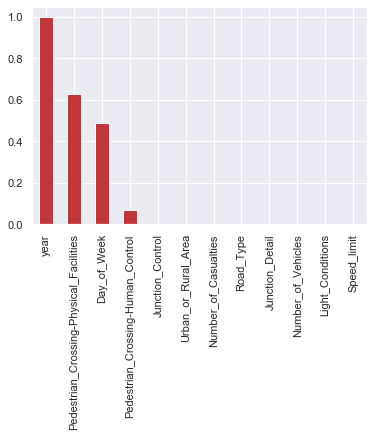

In [15]:
chi_scores = chi2(x,y)
p_values = pd.Series(chi_scores[1],index = x.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()
p_values

Number of Vehicles, Road type, Urban or Rural area, Junction detail, Number of casualties, light conditions, and speed limit influence the accident severity in the UK. 

**SelectKfeatures**

Similar to the previous method, the below method evaluates the f-statistic and compares the influence across the predictors to the outcome. 

In [16]:
def select_featuresc(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k=4)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

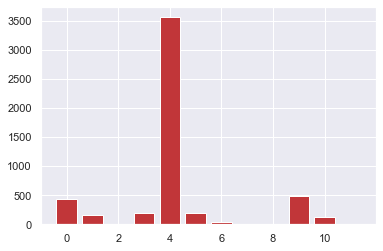

In [17]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 610)
X_train_fs, X_test_fs, fs = select_featuresc(x_train, y_train, x_test)
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()


From the above, we observe that speed limit, light conditions, and number of vehicles contribute most to the severity of the outcome.

**Feature Selection for Police response**


In [18]:
#Data prep
p=test.drop(['Police_Force','Latitude','Longitude','Date','Time','Number_of_Vehicles','Number_of_Casualties','Did_Police_Officer_Attend_Scene_of_Accident','month_year'],axis=1)
p=p.iloc[:,1:]
q=test[['Did_Police_Officer_Attend_Scene_of_Accident']]

**Hypothesis Test**

year                                        8.864370e-01
Pedestrian_Crossing-Human_Control           2.153051e-01
Pedestrian_Crossing-Physical_Facilities     5.900814e-02
Day_of_Week                                 2.909053e-03
Junction_Control                            2.551587e-05
Accident_Severity                           3.880886e-33
Urban_or_Rural_Area                         1.356566e-57
Road_Type                                   1.354599e-70
Light_Conditions                            5.107952e-74
Junction_Detail                            3.435925e-204
Speed_limit                                 0.000000e+00
dtype: float64

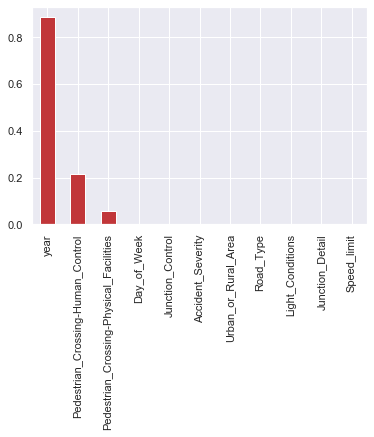

In [19]:
chi_scores2 = chi2(p,q)
chi_scores2
p_values2 = pd.Series(chi_scores2[1],index = p.columns)
p_values2
p_values2.sort_values(ascending = False , inplace = True)
p_values2.plot.bar()
p_values2


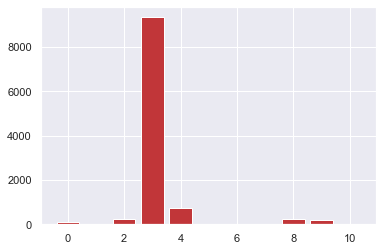

In [20]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(p, q, test_size = 0.2, random_state = 610)
X_train_fs, X_test_fs, fs = select_featuresc(x_train, y_train, x_test)
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()


# Predict Fatal Accidents- Logistic Regresstion

Random under-sampling:
2    2394
1    2394
Name: Accident_Severity, dtype: int64
Num records =  4788
The classification report of OVR:
               precision    recall  f1-score   support

           1       0.66      0.60      0.63      1158
           2       0.66      0.71      0.68      1236

    accuracy                           0.66      2394
   macro avg       0.66      0.66      0.66      2394
weighted avg       0.66      0.66      0.66      2394



C:\Users\sasha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


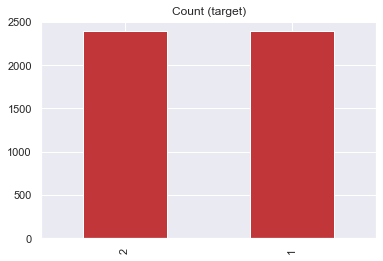

In [21]:
import imblearn

#Handling Imbalanced datasets
log=test
log["Accident_Severity"].replace({3:2}, inplace=True)
count_class_2, count_class_1 = log.Accident_Severity.value_counts()

df_class_2 = log[log['Accident_Severity'] == 2] #majority class
df_class_1 = log[log['Accident_Severity'] == 1] #minority class
df_class_2_under = df_class_2.sample(count_class_1)

df_test_under = pd.concat([df_class_2_under, df_class_1])

print('Random under-sampling:')
print(df_test_under.Accident_Severity.value_counts())
print("Num records = ", df_test_under.shape[0])
df_test_under

df_test_under.Accident_Severity.value_counts().plot(kind='bar', title='Count (target)');
df_test_under.to_csv('undersample.csv')

#Logistic Regression

#Feature input
x1=df_test_under[['Road_Type','Junction_Detail','Urban_or_Rural_Area','Light_Conditions','Speed_limit','Number_of_Vehicles','Number_of_Casualties']]
y1=df_test_under[['Accident_Severity']] #Outcome variable

x_train, x_test, y_train, y_test = model_selection.train_test_split(x1, y1, test_size = 0.5, random_state = 450)
ovr_estimator = linear_model.LogisticRegression(
    solver = 'lbfgs',
    multi_class = 'ovr',max_iter=1000)
ovr_estimator.fit(x_train, y_train)
ovr_predict = ovr_estimator.predict(x_test)
print('The classification report of OVR:\n {}'
      .format(metrics.classification_report(y_test, ovr_predict)))




# Decision Tree Classification

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.20, random_state=450)
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[325 151]
 [173 309]]
              precision    recall  f1-score   support

           1       0.65      0.68      0.67       476
           2       0.67      0.64      0.66       482

    accuracy                           0.66       958
   macro avg       0.66      0.66      0.66       958
weighted avg       0.66      0.66      0.66       958



The classification results for the decision tree and logistic regression are available. It gives us an understanding of the better prediction model given the dataset. 

In our case, logistic regression performs slightly better given the dataset at our disposal and the F1-score that measures the performance across precision, recall, and the contingency matrix (TP, TN, FP, and FN) . Hence, our first choice will be to use logistic regression for classification purposes. 

# Recommendation and Insights

**Accident Severity**

Insight #1- Lighting Conditions

From the hypothesis confirmation, we observe that the darker the lighting the higher the chances of fatal accidents. Moreover, the % of fatal accidents are higher in rural areas where there is lesser lighting indicating a clear association between lighting and fatal accidents.

This is also proven by the below graph visualizin volume of accidents in dark and bright areas in rural and urban areas. In the below visualization, figure on the left indicates daylight and well lit streets, the accidents are higher in urban areas as compared to rural areas. On the other hand, the figure on the right indicates higher number of accidents in the darker regions in the rural areas. 

Recommendation #1

The goal of the state bodies must be to reduce the occurences of the accidents. Increasing the lighting in rural regions in high accident prone areas will significantly reduce the occurences of the fatal accidents in rural areas. 



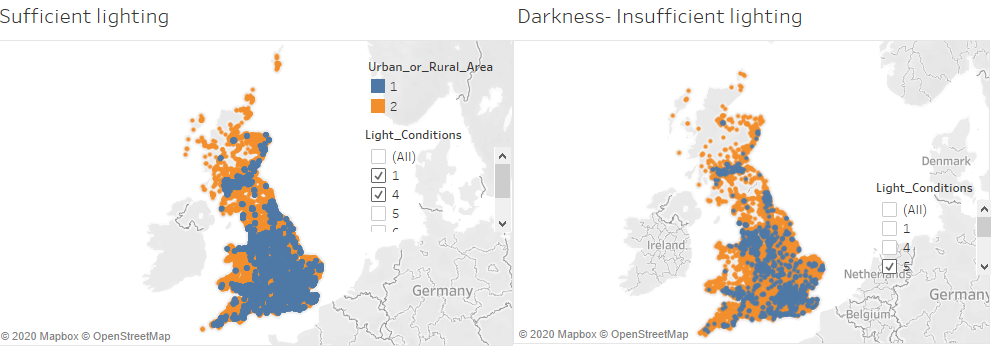

In [23]:
from IPython.display import Image
Image(filename = "1.png", width = 600, height = 700)

Insight #2- Road Type

Road type, junction detail, junction control has significant impact on the severity of the accidents. Roundabout, T junctions, and cross roads significantly contribute to 51% of the total accidents. The hypothesis test performed proves the statistical significance of the case. 

Recommendation #2

Increasing safety measures and benchmarks around Roundabout, T junctions, and cross roads significantly reduces the occurences of the fatal accidents.

Insight #3- Speed limit

Speed limit contributes most to the severity of the accident. 66% of the fatal accidents occur in the regions where travellers travel in the 30KM/hr or 60 KM/hr speed limit. Speed light influences police response to the accident. 30% of the fatal accidents take place in the 30 KM/hr bracket, whereas 36% of the accidents take place in the 60 KM/hr bracket.

Recommendation #3

Designing optimal speed limit is the single biggest change that would bring down the occurences of the accident. Too slow a speed limit, or too high a speed limit could cause accidents and increase the severity. The optimal level will ensure reduced occurences of fatal accidents. 

**Police Response**

Insight #1

The police response is generally higher for more severe accidents. In addition, we have observed the number of accidents are higher in urban areas. Moreover, the police response is lower in urban areas compared to the police response in rural areas. 

This indicates a supply demand problem with respect to police to accidents ratio. 

Recommendation #1

Increasing police presence in urban areas in high accident prone regions will improve the police response to accidents in the area. 

Insight #2 Lighting and Speed Limit

Addressing the problems of lighting and speed limit could influence the police response and attendance to the accidents. 




